# 50 MeV D on Ta 

This notebook documents the steps taken to calibrate, aquire, and analyze data from activation foils used to unfold the neutron spectrum from 50 MeV D breakup on Ta.  

This Notebook is broken into the following main sections: <br\>
1) Simulated Results <br\>
2) Simulated Unfold <br\>
3) Calibration <br\>
4) Count Plan <br\>
5) Experimental Setup <br\>

The notebook has dependecies on PyScripts, which can be cloned from:
https://github.com/jamesbevins/PyScripts

In [2]:
import os
import sys
import peakutils

import pandas as pd
import numpy as np
import copy as cp

from math import sqrt, exp, log
from datetime import datetime
from scipy.optimize import curve_fit
from peakutils.plot import plot as pplot
from matplotlib import pyplot
%matplotlib inline

# Path to PyScripts support functions 
sys.path.insert(0,os.path.abspath('/home/pyne-user/Dropbox/UCB/Computational_Tools/Scripts/Python/src/GeneralNuclear'))
from Counting import parse_spe, simple_peak_counts, germanium_eff_exp, foil_count_time, volume_solid_angle, \
                     optimal_count_plan, germanium_eff_poly, ge_peakfit, get_peak_windows, find_best_fit, \
                     germanium_eff, channel_statistics, count_plan
from BasicNuclearCalcs import decay, production_decay, get_decay_const, fractional_solid_angle
sys.path.insert(0,os.path.abspath('/home/pyne-user/Dropbox/UCB/Computational_Tools/Scripts/Python/src/DataAnalysis'))
from Stats import red_chisq, curve_fit_error4

## Simulated Results

### MCNP

The experimental configuration was simulated in MCNP to get the expected reaction rates.  The Meulder's deuterons on 197Au was used as the source, and the foil pack was suspended center beam 34.62 cm from the wall.

The results are located at <path>\Dropbox\UCB\Research\ETAs\88Inch\Data\Simulated\Activation\16MeVTa\Model

They are sumarized at:

In [3]:
simFoilPath = "/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Simulated/Activation/33MevTa/ETA/33MeVEtaFoils.xlsx"
simFpPath = "/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Simulated/Activation/33MevTa/ETA/33MeVEtaFPs.xlsx"

## Simulated Unfold

Unfold of the MCNP results to test the theroretical ability to unfold given a set of reaction channels.  

## Calibration

### Import source data

Calibration was performed using Cs137, Co60, Eu 152, Am241, and Ba133 sources. The lines used for energy and efficiency calibration are:

#### Position 18 cm

Source   | Line (keV)| BR [%] | Time  | Filename
-------- |:---------:|:------:|:-----:|:----------------:
Cs137    |661.657    |85.10   |0733   |Cs137_18_0737_26Feb17
Co60     |1173.23    |99.85   |0746   |Co60_18_0759_26Feb17
Co60     |1332.49    |99.98   |0746   |Co60_18_0759_26Feb17
Am241    |59.54      |2.14    |0804   |Am241_18_0737_26Feb17
Ba133    |80.9979    |32.9    |0850   |Ba133_18_0921_26Feb17
Ba133    |276.40     |7.16    |0850   |Ba133_18_0921_26Feb17
Ba133    |302.85     |18.34   |0850   |Ba133_18_0921_26Feb17
Ba133    |356.01     |62.05   |0850   |Ba133_18_0921_26Feb17
Eu152    |121.70     |20.56   |0936   |Eu152_18_0737_26Feb17
Eu152    |244.70     |5.44    |0936   |Eu152_18_0737_26Feb17
Eu152    |344.29     |7.42    |0936   |Eu152_18_0737_26Feb17
Eu152    |778.90     |3.61    |0936   |Eu152_18_0737_26Feb17
Eu152    |964.06     |10.46   |0936   |Eu152_18_0737_26Feb17
Eu152    |1112.08    |9.85    |0936   |Eu152_18_0737_26Feb17
Eu152    |1408.01    |15.04   |0936   |Eu152_18_0737_26Feb17

#### Position 1 cm

The drawer was a little loose in the stack.  It was pushed to back right for repeatibility.

Source   | Line (keV)| BR [%] | Time  | Filename
-------- |:---------:|:------:|:-----:|:----------------:
Cs137    |661.657    |85.10   |1013   |Cs137_1_1015_26Feb17
Co60     |1173.23    |99.85   |1018   |Co60_1_1020_26Feb17
Co60     |1332.49    |99.98   |1018   |Co60_1_1020_26Feb17
Am241    |59.54      |2.14    |1024   |Am241_1_1025_26Feb17
Ba133    |80.9979    |32.9    |1029   |Ba133_1_0921_26Feb17
Ba133    |276.40     |7.16    |1029   |Ba133_1_0921_26Feb17
Ba133    |302.85     |18.34   |1029   |Ba133_1_0921_26Feb17
Ba133    |356.01     |62.05   |1029   |Ba133_1_0921_26Feb17
Eu152    |121.70     |20.56   |1036   |Eu152_1_1048_26Feb17
Eu152    |244.70     |5.44    |1036   |Eu152_1_1048_26Feb17
Eu152    |344.29     |7.42    |1036   |Eu152_1_1048_26Feb17
Eu152    |778.90     |3.61    |1036   |Eu152_1_1048_26Feb17
Eu152    |964.06     |10.46   |1036   |Eu152_1_1048_26Feb17
Eu152    |1112.08    |9.85    |1036   |Eu152_1_1048_26Feb17
Eu152    |1408.01    |15.04   |1036   |Eu152_1_1048_26Feb17

This data, along with the initial activity and decay information, is also located in the excel file located here:

In [10]:
calibSourcesPath = '/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Experiments/Activation/33MeVTa_25Apr/CalibrationSources.xlsx'

Import the source and activity data and format for later analysis:

In [11]:
sources = pd.read_excel(calibSourcesPath, "Sources")
sources.columns = ['source', 'initActivity', 'initActRelUncert', 'initDate', 'halfLife']
sources.index = sources.source
del sources['source']
sources['initDate'] = pd.to_datetime(sources['initDate'])
sources['measDate'] = 0     

print "The calibration source data used: \n\n", sources

The calibration source data used: 

        initActivity  initActRelUncert   initDate      halfLife  measDate
source                                                                   
Am241         10.300           0.01165 1970-01-01  1.364420e+10         0
Eu152          1.062           0.01165 2009-01-01  4.263262e+08         0
Co60           1.007           0.01165 2009-01-01  1.663442e+08         0
Cs137          1.042           0.01165 2009-01-01  9.487232e+08         0
Ba133          1.078           0.01165 2009-01-01  3.327363e+08         0


Import the calibration line and branching ratio data:

In [12]:
lines = pd.read_excel(calibSourcesPath,"Lines")
lines.columns=['isotope','line','branchingRatio']
print "The calibration peak data used: \n\n", lines

The calibration peak data used: 

      isotope       line  branchingRatio
0       Am241    59.5409        0.359000
1   Cs137       661.6570        0.851000
2   Co60       1173.2300        0.998500
3   Co60       1332.4900        0.999826
4   Ba133        80.9979        0.329000
5   Ba133       276.4000        0.071600
6   Ba133       302.8500        0.183400
7   Ba133       356.0100        0.620500
8   Eu152       121.7000        0.285300
9   Eu152       244.7000        0.075500
10  Eu152       344.2900        0.265900
11  Eu152       778.9000        0.129300
12  Eu152       964.0600        0.145100
13  Eu152      1085.8370        0.101100
14  Eu152      1112.0800        0.136700
15  Eu152      1408.0100        0.208700


### Perform software energy calibration

The energy calibration was performed using GammaVision.

[insert calibration procedure here]

### Read in the calibration data

Read in all of the data taken for calibration.  

This procedure assumes: <br/>
1) That there is a folder with only calibration data in the format "isotope_position_anything.Spe".  For example, a valid naming convention is "Co60_1_8Feb17.Spe".  The first field is used to compare against the imported lines, and the second field is to build a location dependent calibration. <br/>
2) Only calibration data lives in the calibration path specified.  <br/>
3) That the calibration order listed above in the table was followed. <br/>

The path the calibration data is:

In [14]:
calibDataPath = '/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Experiments/Activation/33MeVTa_25Apr/Calibration/'

# Variables to allow for multiple positions to be handled at once
posSet = False
posUsed = []

# Storage for parameters that vary by position
liveTime = {}
eCalibParams = {} #ax^2 +bx + c stored as (a,b,c)
data = {}

# Loop over all files
for filename in os.listdir(calibDataPath):
    if filename.endswith(".Spe"): 
        name = os.path.splitext(filename)[0]
        
        # Read data from this file
        print "Processing:", filename
        (time, t, measDate, a, b, c, tmpData) = parse_spe(calibDataPath+filename)
        
        # Determine position, update data structures if necessary, and store data
        position = int(name.split('_')[1])
        if position not in posUsed:
            posUsed.append(position)
            liveTime[position] = {}
            data[position] = tmpData
            data[position].columns = [name.split('_')[0]]
        else: 
            data[position].loc[:,name.split('_')[0]] = tmpData['counts']
        if name.split('_')[0] in sources.index:
            sources.at[name.split('_')[0], 'measDate'] = measDate
            liveTime[position][name.split('_')[0]] = time
            if name.split('_')[0] == "Eu152":
                eCalibParams[position] = (a, b, c)
for p in posUsed:
    print "\nPosition = {} cm".format(p)
    print "LiveTime:", liveTime[p]
    print "Energy Calibration: {}*ch^2 + {} * ch + {}".format(eCalibParams[p][0],eCalibParams[p][1],eCalibParams[p][2])
    print data[p].head(3)

Processing: Eu152_1.Spe
Processing: Y88_1.Spe
Processing: Eu152_5.Spe
Processing: Cs137_18.Spe
Processing: Co60_10.Spe
Processing: Cs137_5.Spe
Processing: Ba133_1.Spe
Processing: Co60_1.Spe
Processing: Y88_5.Spe
Processing: Cs137_1.Spe
Processing: Co60_18.Spe
Processing: Am241_10.Spe
Processing: Am241_1.Spe
Processing: Ba133_10.Spe
Processing: Y88_18.Spe
Processing: Eu152_18.Spe
Processing: Am241_18.Spe
Processing: Eu152_10.Spe
Processing: Ba133_18.Spe
Processing: Y88_10.Spe
Processing: Co60_5.Spe
Processing: Cs137_10.Spe
Processing: Am241_5.Spe
Processing: Ba133_5.Spe

Position = 1 cm
LiveTime: {'Co60': 61.0, 'Cs137': 61.0, 'Ba133': 397.0, 'Am241': 126.0, 'Eu152': 193.0}
Energy Calibration: 7.56672e-09*ch^2 + 0.3972623 * ch + -0.4220292
   Eu152  Y88  Ba133  Co60  Cs137  Am241
0      0    0      0     0      0      0
1      0    0      0     0      0      0
2      0    0      0     0      0      0

Position = 5 cm
LiveTime: {'Cs137': 69.0, 'Co60': 94.0, 'Ba133': 322.0, 'Am241': 64.0, 

### Calculate the peak counts

Determine the peak area for each of the lines considered.  Save the data in the lines dataframe. 

This procedure assumes: <br/>
1) That no significant background is present.  No background subtraction is performed. <br/>
2) A linear interpolation of the continuum is sufficient.  <br/>

There is an alternate, more sophisticated procedure immediately following this set of code.  This portion of code is redunant, but kept for now. If this peak fitting method is preferred, then change the cell to code and do not run the next peak fitting routine.   

# Create a dictionary of data frames to store each of the positional information
peakData = {}

for p in posUsed:
    print "\n------------------------"
    print "Position = {} cm".format(p)
    print "------------------------"
    # Update dataframe to store calculated peak information
    lines['measuredCounts'] = 0     
    lines['measUncert'] = 0
    for column in data[p]:
        
        # Find the peaks 
        channels = np.asarray(data[p].index)
        energy = eCalibParams[p][2]+eCalibParams[p][1]*channels+eCalibParams[p][0]*channels**2
        counts = np.asarray(data[p][column]).astype(float)
        peaks = peakutils.indexes(counts, thres=0.01, min_dist=10)
        
        # Loop over all identified peaks to compare against calibration points loaded previously
        print "\n", data[p][column].name, "\nEnergy  Counts     Area"      
        for i in range(len(lines['line'])):
            for e, c, pk in zip(energy[peaks], counts[peaks], peaks):
                # Calculate the total peak counts if a calibration peak
                if abs(e-lines['line'][i]) < 1 and data[p][column].name.strip() == lines['isotope'][i].strip():
                    (lines.at[i, 'measuredCounts'], lines.at[i, 'measUncert']) = simple_peak_counts(channels, counts, pk)
                    print "{:.2f}   {:.0f}   {:.2f}".format(e, c, lines.at[i, 'measuredCounts'])
            lines.at[i, 'isotope'] = lines.at[i, 'isotope'].strip()
        print "\n"
        
        # Plot the peaks found
        fig = pyplot.figure(figsize=(5,3))
        ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
        ax1.set_yscale('log')
        pplot(energy, counts, peaks)
        pyplot.title('Peaks @ {} cm for {}'.format(p,data[p][column].name))        
        pyplot.show()
        
    print lines
    peakData[p] = cp.deepcopy(lines)

### Calculate the peak counts

Determine the peak area for each of the lines considered.  Save the data in the lines dataframe. 

This procedure assumes: <br/>
1) That no significant background is present.  No background subtraction is performed. <br/>  


------------------------
Position = 1 cm
------------------------

Eu152 
Energy  Peak Area
121.94   163516   404
244.69   23551   153
344.41   83744   289
779.04   18722   136
964.18   14578   120
1086.54   14519   120

/home/pyne-user/Dropbox/UCB/Computational_Tools/Scripts/Python/src/DataAnalysis/Math.py:104: RuntimeWarning: overflow encountered in exp
  return amplitude*(np.exp(rng*z))/(1+np.exp(z))**4
/home/pyne-user/Dropbox/UCB/Computational_Tools/Scripts/Python/src/DataAnalysis/Math.py:104: RuntimeWarning: overflow encountered in multiply
  return amplitude*(np.exp(rng*z))/(1+np.exp(z))**4



1112.37   12359   111
1408.76   15340   123




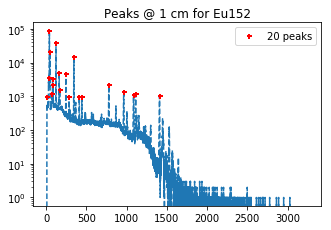


Y88 
Energy  Peak Area




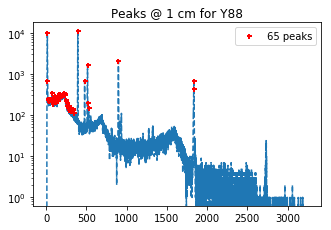


Ba133 
Energy  Peak Area
81.02   407238   638
276.47   35865   189
303.09   98173   313
355.93   290038   538




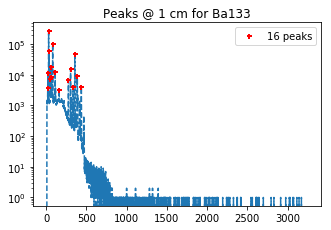


Co60 
Energy  Peak Area
1173.55   18324   135
1333.27   16556   128




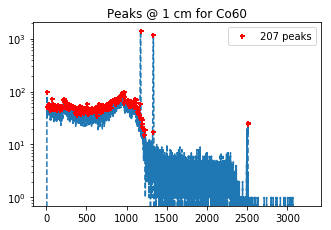


Cs137 
Energy  Peak Area
661.84   70443   265




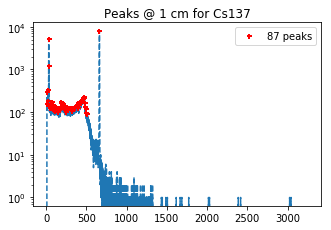


Am241 
Energy  Peak Area
59.56   2513868   1585




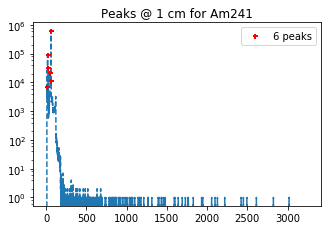

   isotope       line  branchingRatio  measuredCounts  measUncert
0    Am241    59.5409        0.359000         2513868        1585
1    Cs137   661.6570        0.851000           70443         265
2     Co60  1173.2300        0.998500           18324         135
3     Co60  1332.4900        0.999826           16556         128
4    Ba133    80.9979        0.329000          407238         638
5    Ba133   276.4000        0.071600           35865         189
6    Ba133   302.8500        0.183400           98173         313
7    Ba133   356.0100        0.620500          290038         538
8    Eu152   121.7000        0.285300          163516         404
9    Eu152   244.7000        0.075500           23551         153
10   Eu152   344.2900        0.265900           83744         289
11   Eu152   778.9000        0.129300           18722         136
12   Eu152   964.0600        0.145100           14578         120
13   Eu152  1085.8370        0.101100           14519         120
14   Eu152

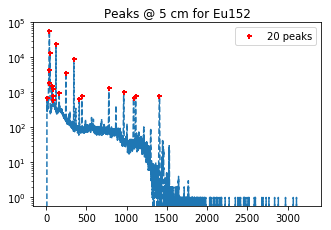


Cs137 
Energy  Peak Area
661.47   21897   147




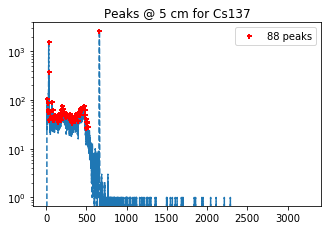


Y88 
Energy  Peak Area




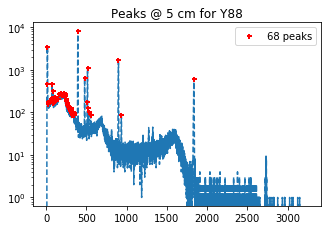


Co60 
Energy  Peak Area
1173.58   8307   91
1333.30   7511   86




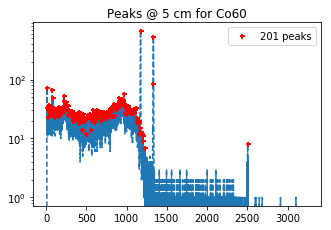


Am241 
Energy  Peak Area
59.18   351027   592




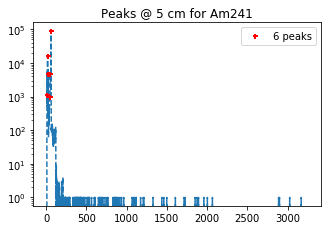


Ba133 
Energy  Peak Area
81.03   111240   333
276.49   11448   106
303.11   27731   166
356.35   82137   286




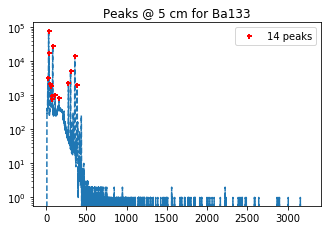

   isotope       line  branchingRatio  measuredCounts  measUncert
0    Am241    59.5409        0.359000          351027         592
1    Cs137   661.6570        0.851000           21897         147
2     Co60  1173.2300        0.998500            8307          91
3     Co60  1332.4900        0.999826            7511          86
4    Ba133    80.9979        0.329000          111240         333
5    Ba133   276.4000        0.071600           11448         106
6    Ba133   302.8500        0.183400           27731         166
7    Ba133   356.0100        0.620500           82137         286
8    Eu152   121.7000        0.285300          104120         322
9    Eu152   244.7000        0.075500           17874         133
10   Eu152   344.2900        0.265900           48978         221
11   Eu152   778.9000        0.129300           11791         108
12   Eu152   964.0600        0.145100           10562         102
13   Eu152  1085.8370        0.101100            8520          92
14   Eu152

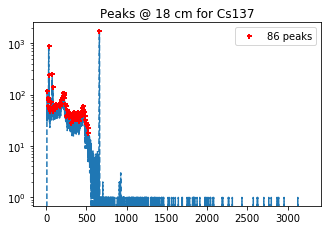


Co60 
Energy  Peak Area
1173.68   11259   106
1333.41   10429   102




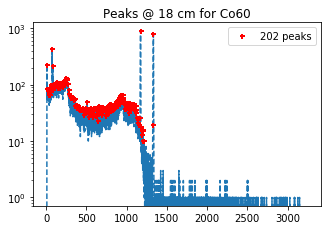


Y88 
Energy  Peak Area




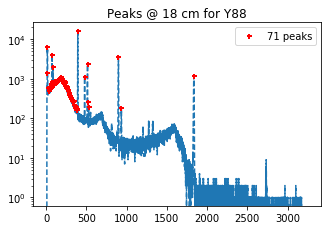


Eu152 
Energy  Peak Area
121.97   84957   291
244.75   16205   127
344.47   41220   203
778.75   10256   101
963.90   9769   98
1085.88   7083   84
1112.50   8151   90
1408.10   10439   102




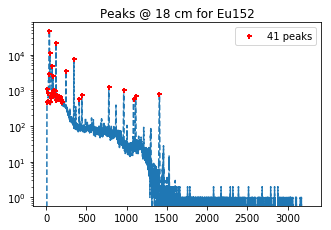


Am241 
Energy  Peak Area
59.59   44783   211




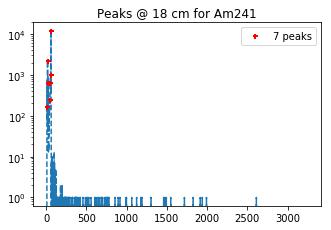


Ba133 
Energy  Peak Area
81.05   90459   300
276.53   10608   102
303.15   24541   156
356.00   72678   269




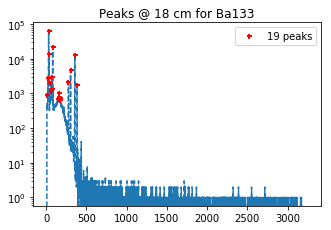

   isotope       line  branchingRatio  measuredCounts  measUncert
0    Am241    59.5409        0.359000           44783         211
1    Cs137   661.6570        0.851000           13758         117
2     Co60  1173.2300        0.998500           11259         106
3     Co60  1332.4900        0.999826           10429         102
4    Ba133    80.9979        0.329000           90459         300
5    Ba133   276.4000        0.071600           10608         102
6    Ba133   302.8500        0.183400           24541         156
7    Ba133   356.0100        0.620500           72678         269
8    Eu152   121.7000        0.285300           84957         291
9    Eu152   244.7000        0.075500           16205         127
10   Eu152   344.2900        0.265900           41220         203
11   Eu152   778.9000        0.129300           10256         101
12   Eu152   964.0600        0.145100            9769          98
13   Eu152  1085.8370        0.101100            7083          84
14   Eu152

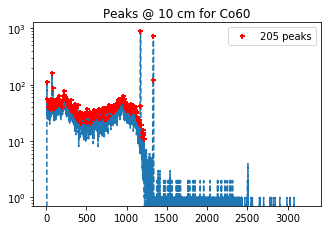


Am241 
Energy  Peak Area
59.61   120763   347




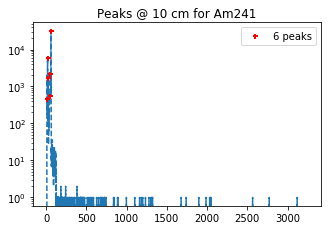


Ba133 
Energy  Peak Area
81.06   87671   296
276.49   9680   98
303.11   23515   153
355.94   68812   262




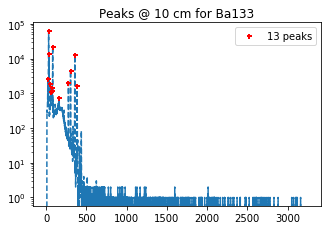


Eu152 
Energy  Peak Area
121.98   177371   421
244.71   32512   180
344.42   83229   288
779.39   20874   144
964.51   19283   138
1086.08   8672   93
1408.27   20432   142




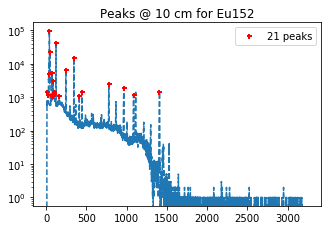


Y88 
Energy  Peak Area




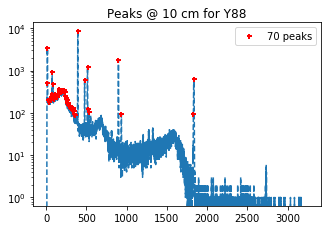


Cs137 
Energy  Peak Area
661.41   10435   102




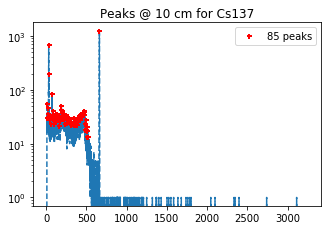

   isotope       line  branchingRatio  measuredCounts  measUncert
0    Am241    59.5409        0.359000          120763         347
1    Cs137   661.6570        0.851000           10435         102
2     Co60  1173.2300        0.998500           11166         105
3     Co60  1332.4900        0.999826           10208         101
4    Ba133    80.9979        0.329000           87671         296
5    Ba133   276.4000        0.071600            9680          98
6    Ba133   302.8500        0.183400           23515         153
7    Ba133   356.0100        0.620500           68812         262
8    Eu152   121.7000        0.285300          177371         421
9    Eu152   244.7000        0.075500           32512         180
10   Eu152   344.2900        0.265900           83229         288
11   Eu152   778.9000        0.129300           20874         144
12   Eu152   964.0600        0.145100           19283         138
13   Eu152  1085.8370        0.101100            8672          93
14   Eu152

In [15]:
# Create a dictionary of data frames to store each of the positional information
peakData = {}
for p in posUsed:
    print "\n------------------------"
    print "Position = {} cm".format(p)
    print "------------------------"
    
    # Update dataframe to store calculated peak information
    lines['measuredCounts'] = 0     
    lines['measUncert'] = 0
    
    for column in data[p]:    
        # Find the peaks and set the windows
        channels = np.asarray(data[p].index)
        counts = np.asarray(data[p][column]).astype(float)
        energy = eCalibParams[p][2]+eCalibParams[p][1]*channels+eCalibParams[p][0]*channels**2
        peaks = peakutils.indexes(counts, thres=0.01, min_dist=10)
        windows = get_peak_windows(peaks)
        
        # Loop over all identified peaks to compare against calibration points loaded previously
        print "\n", data[p][column].name, "\nEnergy  Peak Area"      
        for i in range(len(lines['line'])):
            for e, pk in zip(energy[peaks], peaks):
                # Calculate the total peak counts if a calibration peak
                if abs(e-lines['line'][i]) < 1.75 and data[p][column].name.strip() == lines['isotope'][i].strip():
                    pkChannels = channels[windows[pk][0]:windows[pk][1]]
                    pkCounts = counts[windows[pk][0]:windows[pk][1]]
                    (lines.at[i, 'measuredCounts'], lines.at[i, 'measUncert'], redChiSq) = \
                                 ge_peakfit(pkChannels, pkCounts)
                    
                    print "{:.2f}   {:.0f}   {:.0f}".format(e, lines.at[i, 'measuredCounts'], lines.at[i, 'measUncert'])
            lines.at[i, 'isotope'] = lines.at[i, 'isotope'].strip()
        print "\n"
        
        # Plot the peaks found
        fig = pyplot.figure(figsize=(5,3))
        ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
        ax1.set_yscale('log')
        pplot(energy, counts, peaks)
        pyplot.title('Peaks @ {} cm for {}'.format(p,data[p][column].name))        
        pyplot.show()
        
    print lines
    peakData[p] = cp.deepcopy(lines)

####TMP#### - Can remove once satisfied that peak fitting is working correctly
# Find the peaks 
channels = np.asarray(data[18].index)
energy = eCalibParams[18][2]+eCalibParams[18][1]*channels+eCalibParams[18][0]*channels**2
counts = np.asarray(data[18]['Eu152']).astype(float)
peaks = peakutils.indexes(counts, thres=0.015, min_dist=10)
print peaks

window = get_peak_windows(peaks)
#peaks = [210, 720, 927] # Ba133
#peaks = [317, 637, 896, 2028, 2510, 2897, 3666] #Eu152@1
#peaks = [317, 637, 897, 2028, 2510, 2897, 3666] #Eu152@10
peaks = [317, 638, 897, 2029, 2511, 2897, 3668] #Eu152@18
peaks = [638] #Eu152@18
#peaks = [3055, 3469]

# Loop over all identified peaks to compare against calibration points loaded previously
for pk in peaks:
    pkChannels = channels[window[pk][0]:window[pk][1]]
    pkCounts = counts[window[pk][0]:window[pk][1]]
    (peakCounts, peakStd, redChiSq) = ge_peakfit(pkChannels, pkCounts)
    
    print "{:.2f}   {:.2f}   {:.2f}".format(energy[pk], peakCounts, peakStd)

## Propogation of fitting error?
import sys
import os
sys.path.insert(0,os.path.abspath('/home/pyne-user/Dropbox/UCB/Computational_Tools/Scripts/Python/DataAnalysis'))
from Math import gaussScalar
#from sympy import symbols, diff
import theano
#x, a, b, c = symbols('x a b c')
#print diff(gaussScalar(x, a, b, c), x)

### Calculate the current activity

Using the data read in from the .spe files, calculate the current activity at the time of the measurement.  

NOTE:  There is a mix in the activity units.  The initActivity is in $\mu$Ci as reported on the source, whereas the curActivity in is Bq.

In [16]:
sources['curActivity'] = 0
for src in sources.index:
    sources.at[src, 'curActivity'] = decay(sources.at[src, 'halfLife'],sources.at[src, 'initActivity'], \
                                        (sources.at[src, 'measDate']-sources.at[src, 'initDate']).total_seconds())
print sources   

        initActivity  initActRelUncert   initDate      halfLife  \
source                                                            
Am241         10.300           0.01165 1970-01-01  1.364420e+10   
Eu152          1.062           0.01165 2009-01-01  4.263262e+08   
Co60           1.007           0.01165 2009-01-01  1.663442e+08   
Cs137          1.042           0.01165 2009-01-01  9.487232e+08   
Ba133          1.078           0.01165 2009-01-01  3.327363e+08   

                   measDate  curActivity  
source                                    
Am241   2017-04-19 11:24:51       353270  
Eu152   2017-04-19 12:33:53        25670  
Co60    2017-04-19 11:29:55        12514  
Cs137   2017-04-19 12:11:07        31841  
Ba133   2017-04-19 11:32:47        23117  


### Calculate absolute effficiency

Determine an absolute efficiency curve for each position by curve fitting the experimental data. The germanium_eff_exp function has support for propogation of error, but the germanium_eff, or germanium_eff_poly are also available.  

NOTE: The choice of which functions to onsider can be set with the functions list.

NOTE: The uncertainty only currently captures the uncertainity in the counts and initial activity.  The uncertaities in BR, half lives, and measurement time are sufficiently small that they can be ignored, but there is uncertainty associated with the fit of the peak that is not captured if germanium_eff_exp is not used.  

The fitting function was: germanium_eff_exp
The curve fitting parameters at 1 cm are: [  6.33923717e-08   2.67659987e+00   4.94057319e-01   6.18141163e-01]
  with standard deviations at 1 cm of: [  1.12404975e-07   2.39051623e-01   2.24115596e-02   9.43542898e-03]

   isotope       line  expectedCounts  absEfficiency  effUncert
0    Am241    59.5409    1.597982e+07       0.157315   0.001833
1    Cs137   661.6570    1.652898e+06       0.042618   0.000497
2     Co60  1173.2300    7.622090e+05       0.024041   0.000280
3     Co60  1332.4900    7.632212e+05       0.021692   0.000253
4    Ba133    80.9979    3.019381e+06       0.134875   0.001571
5    Ba133   276.4000    6.571053e+05       0.054580   0.000636
6    Ba133   302.8500    1.683144e+06       0.058327   0.000680
7    Ba133   356.0100    5.694607e+06       0.050932   0.000593
8    Eu152   121.7000    1.413465e+06       0.115685   0.001348
9    Eu152   244.7000    3.740504e+05       0.062962   0.000734
10   Eu152   344.2900    1.317

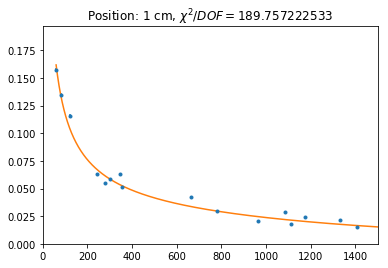

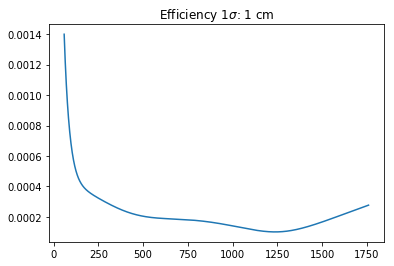

The fitting function was: germanium_eff_exp
The curve fitting parameters at 5 cm are: [  9.16269375e+03  -1.66404545e+00   4.55039418e-01   8.15578341e-01]
  with standard deviations at 5 cm of: [  6.34216310e+03   1.70972312e-01   2.15220983e-02   7.02595734e-03]

   isotope       line  expectedCounts  absEfficiency  effUncert
0    Am241    59.5409    8.116732e+06       0.043247   0.000504
1    Cs137   661.6570    1.869672e+06       0.011712   0.000136
2     Co60  1173.2300    1.174552e+06       0.007072   0.000082
3     Co60  1332.4900    1.176111e+06       0.006386   0.000074
4    Ba133    80.9979    2.448969e+06       0.045423   0.000529
5    Ba133   276.4000    5.329671e+05       0.021480   0.000250
6    Ba133   302.8500    1.365170e+06       0.020313   0.000237
7    Ba133   356.0100    4.618800e+06       0.017783   0.000207
8    Eu152   121.7000    2.753693e+06       0.037811   0.000441
9    Eu152   244.7000    7.287200e+05       0.024528   0.000286
10   Eu152   344.2900    2.566

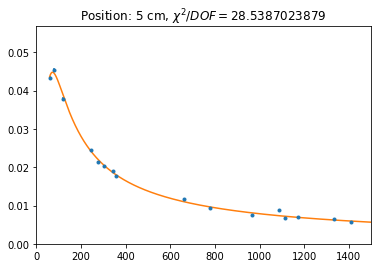

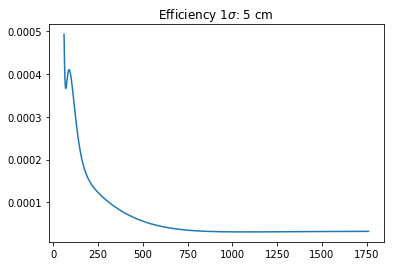

The fitting function was: germanium_eff_exp
The curve fitting parameters at 18 cm are: [  2.94061394e+00   8.13820519e-01   6.85446885e+04  -1.62540601e+00]
  with standard deviations at 18 cm of: [  1.45948082e-01   7.34964720e-03   3.69731105e+04   1.32816858e-01]

   isotope       line  expectedCounts  absEfficiency  effUncert
0    Am241    59.5409    7.736260e+06       0.005789   0.000067
1    Cs137   661.6570    8.101911e+06       0.001698   0.000020
2     Co60  1173.2300    1.059595e+07       0.001063   0.000012
3     Co60  1332.4900    1.061003e+07       0.000983   0.000011
4    Ba133    80.9979    1.393326e+07       0.006492   0.000076
5    Ba133   276.4000    3.032285e+06       0.003498   0.000041
6    Ba133   302.8500    7.767053e+06       0.003160   0.000037
7    Ba133   356.0100    2.627839e+07       0.002766   0.000032
8    Eu152   121.7000    1.548952e+07       0.005485   0.000064
9    Eu152   244.7000    4.099050e+06       0.003953   0.000046
10   Eu152   344.2900    1.4

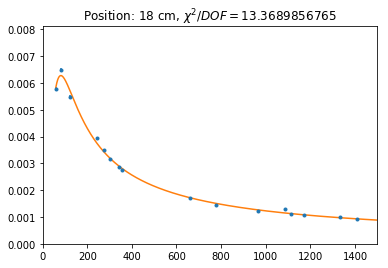

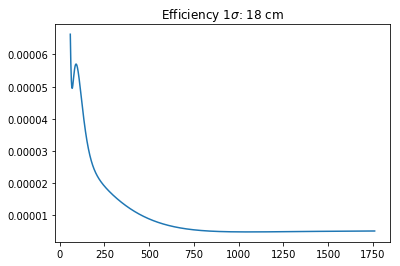

No fit was found
   isotope       line  expectedCounts  absEfficiency  effUncert
0    Am241    59.5409    7.736260e+06       0.015610   0.000182
1    Cs137   661.6570    2.357412e+06       0.004426   0.000052
2     Co60  1173.2300    3.985978e+06       0.002801   0.000033
3     Co60  1332.4900    3.991271e+06       0.002558   0.000030
4    Ba133    80.9979    5.164130e+06       0.016977   0.000198
5    Ba133   276.4000    1.123865e+06       0.008613   0.000100
6    Ba133   302.8500    2.878728e+06       0.008169   0.000095
7    Ba133   356.0100    9.739643e+06       0.007065   0.000082
8    Eu152   121.7000    1.218656e+07       0.014555   0.000170
9    Eu152   244.7000    3.224973e+06       0.010081   0.000117
10   Eu152   344.2900    1.135789e+07       0.007328   0.000085
11   Eu152   778.9000    5.523034e+06       0.003779   0.000044
12   Eu152   964.0600    6.197929e+06       0.003111   0.000036
13   Eu152  1085.8370    4.318474e+06       0.002008   0.000023
14   Eu152  1112.0800  

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:666: RuntimeWarning: divide by zero encountered in true_divide
  weights = 1.0 / asarray(sigma) if sigma is not None else None
/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


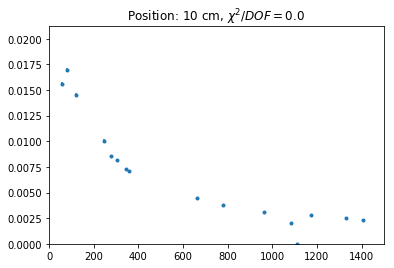

In [17]:
from Counting import germanium_eff
functions=[germanium_eff, germanium_eff_exp]#, germanium_eff_poly]
absEffParams = {}
absEffCov = {}
fitFunc = {} 

for p in posUsed:
    peakData[p]['expectedCounts'] = 0.0
    peakData[p]['absEfficiency'] = 0.0
    peakData[p]['effUncert'] = 0.0
    
    # Calculate the absolute efficiency and uncertainty
    for index, row in peakData[p].iterrows():
        peakData[p].at[index, 'expectedCounts'] = sources.at[peakData[p].at[index, 'isotope'], 'curActivity'] \
                                               * peakData[p].at[index, 'branchingRatio'] \
                                               * liveTime[p][peakData[p].at[index, 'isotope']]
        peakData[p].at[index, 'absEfficiency'] = float(peakData[p].at[index, 'measuredCounts']) \
                                               / float(peakData[p].at[index, 'expectedCounts'])
        peakData[p].at[index, 'effUncert'] = peakData[p].at[index, 'absEfficiency'] * \
                                           sqrt((peakData[p].at[index, 'measUncert'] \
                                           / peakData[p].at[index, 'measuredCounts'])**2 \
                                               + sources.at[peakData[p].at[index, 'isotope'], 'initActRelUncert']**2)
    
    # Fit the data for the current position by finding best fitting routine
    (fitFunc[p], absEffParams[p], absEffCov[p], redChiSq) = find_best_fit(*functions,
                                                     xdata=peakData[p]['line'], ydata=peakData[p]['absEfficiency'],
                                                     sigma=peakData[p]['effUncert'], absolute_sigma=True)
    
    # Output the results
    try:
        print 'The fitting function was: {}'.format(fitFunc[p].__name__)
        print 'The curve fitting parameters at {} cm are: {}'.format(p, absEffParams[p])
        print '  with standard deviations at {} cm of: {}\n'.format(p, np.sqrt(np.diag(absEffCov[p])))
        print peakData[p][['isotope', 'line', 'expectedCounts', 'absEfficiency', 'effUncert']]

        #Plot the Data
        pyplot.axis([0, 1500, 0, 1.25*max(peakData[p]['absEfficiency'])])
        pyplot.errorbar(peakData[p]['line'], peakData[p]['absEfficiency'], peakData[p]['effUncert'], fmt='.')
        pyplot.title('Position: {} cm, $\chi^2/DOF={}$'.format(p, redChiSq))

        #Plot the fit
        xList = np.arange(min(peakData[p]['line']), 1.25*max(peakData[p]['line']), 1)
        yList = map(lambda y: fitFunc[p](y, *absEffParams[p]), xList)
        pyplot.plot(xList, yList)
        pyplot.show()

        #Plot the error
        if fitFunc[p] == germanium_eff_exp:
            pyplot.title('Efficiency 1$\sigma$: {} cm'.format(p))
            xList = np.arange(min(peakData[1]['line']), 1.25*max(peakData[1]['line']), 1)
            yList = map(lambda y: curve_fit_error4(fitFunc[p], np.insert(absEffParams[p], 0, y), y*0.001, 
                                                   absEffCov[p]), xList)
            pyplot.plot(xList, yList)
            pyplot.show()
    except AttributeError:
        print 'No fit was found'
        print peakData[p][['isotope', 'line', 'expectedCounts', 'absEfficiency', 'effUncert']]
        
        #Plot the Data
        pyplot.axis([0, 1500, 0, 1.25*max(peakData[p]['absEfficiency'])])
        pyplot.errorbar(peakData[p]['line'], peakData[p]['absEfficiency'], peakData[p]['effUncert'], fmt='.')
        pyplot.title('Position: {} cm, $\chi^2/DOF={}$'.format(p, redChiSq))
        pyplot.show()

## Count Plan

Develop a count plan based on the planned irradiation. This assumes that you have a priori abs effeciency calibration parameters for the position of interest. 

### Experimental parameters

Specifies experimental parameters for the beam and counting facility used.

runTime = the beam irradiation time in s

transitTime = the minimum time to counting of the first foil in s

background = the background rate at the peak of interest in counts/s

detR = radius of the detector in cm

In [18]:
runTime = 3600*19+32*60
transitTime = 360

background = 0.001
detR = 3.245

### Read in Simulation data

#### Activation Foils
Read from the designated file path.  Manipulate the file to build a dataframe with the information needed for the count plan.  

In [20]:
simFoils = pd.read_excel(simFoilPath)

# Delete unneccesary columns for readability and make the index the reactant
simFoils.index = simFoils.Rx
del simFoils['Rx']
del simFoils['Thickness [cm]']
del simFoils['Density']
del simFoils['AW']
del simFoils['Lambda [s^-1]']

# Rename columns for ease of access and add in the statistics column
simFoils.columns = ['foil', 'product', 'gammaEnergy', 'br', 'relStat', 'det2FoilDist', 'normalization', 'rxRate',
                         'rxRateSigma', 'foilR','weightFrac', 'volume', 'halfLife']

# Put branching ratios in fractional form
simFoils['br'] = simFoils['br']/100.

# Calculate the activity following transit time decay for each rx; delete columns no longer needed
simFoils['initActivity'] = 0.0
simFoils['activityUncert'] = 0.0
for ind in simFoils.index:
    simFoils.at[ind,'initActivity'] = production_decay(simFoils.at[ind, 'halfLife'], 0, runTime, \
                                                    simFoils.at[ind, 'rxRate'], \
                                                    simFoils.at[ind, 'normalization'], \
                                                    simFoils.at[ind, 'volume'], transitTime)\
                                                    *get_decay_const(simFoils.at[ind,'halfLife'])\
                                                    *simFoils.at[ind,'br']
    simFoils.at[ind,'activityUncert'] = simFoils.at[ind, 'initActivity']*simFoils.at[ind, 'rxRateSigma']
del simFoils['rxRate']
del simFoils['normalization']
del simFoils['volume']
del simFoils['rxRateSigma']

print simFoils

            foil product  gammaEnergy      br  relStat  det2FoilDist  foilR  \
Rx                                                                            
27Al(n,p)     Al    Mg27      843.760  0.7180    0.015             1    2.5   
27Al(n,a)     Al    Na24     1368.630  0.9999    0.010             1    2.5   
115In(n,n')   In  In115M      336.241  0.4580    0.010             1    2.5   
115In(n,g)    In  In116M     1293.560  0.8480    0.010             1    2.5   
197Au(n,2n)   Au   Au196      355.700  0.8090    0.010             1    2.5   
197Au(n,g)    Au   Au198      411.800  0.9562    0.010             1    2.5   
58Ni(n,2n)    Ni    Ni57     1377.630  0.8170    0.015             1    2.5   
58Ni(n,p)     Ni    Co58      810.760  0.9945    0.010             1    2.5   
90Zr(n,2n)    Zr    Zr89      909.150  0.9904    0.010             1    2.5   

             weightFrac    halfLife  initActivity  activityUncert  
Rx                                                            

In [ ]:
(simFoils,countTime) = count_plan(simFoils, handleTime=75, detR=detR, background=background, 
                                                    units='Bq', toMinute = True, 
                                                    funcDict=fitFunc, funcParamDict=absEffParams)

#(simFoils,countOrder,countTime) = optimal_count_plan(simFoils, handleTime=75, detR=detR, background=background, 
#                                                    units='Bq', toMinute = True, 
#                                                    funcDict=fitFunc, funcParamDict=absEffParams )

print 'Total count time = {:2e} hrs\n'.format(countTime/60)
#print 'The order of counting is: {}\n'.format(countOrder)
for ind in simFoils.index:
    print "{:15s} {:4.0f} min".format(ind, simFoils.at[ind,"countTime"])

#### NOTES:

1) Ni58(n,2n)Ni57 channel will not be clean.  There will be contributions from Ni60(n,4n)Ni57 (threshold 33.15 MeV) and Ni61(n,5n)Ni57 (threshold 41.09 MeV) channels.  Unfortunatetly, nuclear data does not exist for these channels. <br/>
2) Ni58(n,p)Co58 channel will not be clean.  There will be contributions from Ni60(n,2np)Co58 (threshold 20.32 MeV), Ni61(n,3np)Co58 (threshold 28.27 MeV), and Ni62(n,4np)Co58 (threshold 39.03 MeV) channels.  Unfortunatetly, nuclear data does not exist for these channels. <br/>
3) Zr90(n,2n)Zr89 channel will not be clean.  There will be contributions from Zr91(n,3n)Zr89 (threshold 19.38 MeV), Zr92(n,4n)Zr89 (threshold 28.80 MeV), and Zr94(n,6n)Zr89 (threshold 43.21 MeV) channels.  Unfortunatetly, nuclear data does not exist for these channels. <br/>

#### HEU Foils
Read from the designated file path.  Manipulate the file to build a dataframe with the information needed for the count plan.  

In [23]:
countTime = 0

#Update decay time based on previous foil count time
transitTime+=countTime

# Delete unneccesary columns for readability and make the index the reactant
simFPs = pd.read_excel(simFpPath)
simFPs.index = simFPs.Rx
del simFPs['Rx']
del simFPs['Thickness [cm]']
del simFPs['Density']
del simFPs['AW']
del simFPs['Lambda [s^-1]']
del simFPs['Fission Rx [vol^-1 src^-1]']

# Rename columns for ease of access and add in the statistics column
simFPs.columns = ['foil', 'product', 'gammaEnergy', 'br', 'relStat', 'det2FoilDist', 'normalization', 'rxRate',
                         'rxRateSigma', 'foilR','weightFrac', 'volume', 'halfLife']

# Put branching ratios in fractional form
simFPs['br'] = simFPs['br']/100.

# Calculate the activity following transit time decay for each rx; delete columns no longer needed
simFPs['initActivity'] = 0.0
simFPs['activityUncert'] = 0.0
for ind in simFPs.index:
    simFPs.at[ind,'initActivity'] = production_decay(simFPs.at[ind, 'halfLife'], 0, runTime, \
                                                    simFPs.at[ind, 'rxRate'], \
                                                    simFPs.at[ind, 'normalization'], \
                                                    simFPs.at[ind, 'volume'], transitTime)\
                                                    *get_decay_const(simFPs.at[ind,'halfLife'])\
                                                    *simFPs.at[ind,'br']
    simFPs.at[ind,'activityUncert'] = simFPs.at[ind, 'initActivity']\
                                             *simFPs.at[ind, 'rxRateSigma']
del simFPs['rxRate']
del simFPs['normalization']
del simFPs['volume']
del simFPs['rxRateSigma']

print simFPs

       foil product  gammaEnergy      br  relStat  det2FoilDist  foilR  \
Rx                                                                       
Zr95   U235    Zr95      756.700  0.5438     0.01             1  0.635   
Zr97   U235    Zr97      743.360  0.9309     0.01             1  0.635   
Ag111  U235   Ag111      342.130  0.0670     0.01             1  0.635   
Cd115  U235   Cd115      933.838  0.0200     0.01             1  0.635   
I133   U235    I133      529.900  0.8700     0.01             1  0.635   
Ba140  U235   Ba140      537.300  0.2439     0.01             1  0.635   
Nd147  U235   Nd147       91.105  0.2810     0.01             1  0.635   
Pm151  U235   Pm151      340.100  0.2250     0.01             1  0.635   
Sm153  U235   Sm153      103.200  0.2925     0.01             1  0.635   
Sr92   U235    Sr92     1383.900  0.9000     0.01             1  0.635   
Ru105  U235   Ru105      724.200  0.4450     0.01             1  0.635   
I135   U235    I135     1260.500  0.28

In [ ]:
fpCountTime=7*22*3600
simFPs = channel_statistics(simFPs, fpCountTime, detR=detR, func=germanium_eff_exp,
                             a=absEffParams[1][0], b=absEffParams[1][1], c=absEffParams[1][2],
                             d=absEffParams[1][3])
print simFPs[['initActivity', 'halfLife', 'counts', 'countsUncert', 'countingStat']]

## Experimental Setup

Counted each foil to verify that there was not residual activity.  

NOTE: Foil drawer has some wiggle room in the stack.  It was pushed all the way back and to the right.  This is not quite centered on the detector, but it is repeatable. The foil itself also doesn't quite fit, so it was ensured that the back edge was in the inset for repeatabiility.  

Zr4 0825 Zr4_1_Background_0831_27Feb17
Al4 0831 Al4_1_Background_0836_27Feb17
In4 0838 Ni4_1_Background_0843_27Feb17
Ni4 0844 Ni4_1_Background_0849_27Feb17

Foil was placed at (65.5 cm, 0 cm, -1 cm)

### Beam On

Start time: 0949:55
Current Integrator: 0
Stop Time:
Current Integrator: 

NOTE: First minute of current monitor calibration data is off. It should read 2 $\mu$A, but it reads a little higher. The recalibration was performed ~1 minute in.  

At ~1003 the beam was stopped because the radiation levels on the roof were too high. At ~1041, the beam was turned on at 1 $\mu$A and adjusted downward until safe levels were reached.  It went down to ~650 nA at 1052.  At 1102, approval was received to go back to 2 $\mu$A.  

5:35 delay 

## Experimental Analysis

In [ ]:
eff=germanium_eff_exp(511.0)
std=curve_fit_error4(germanium_eff_exp, np.insert(absEffParams[p], 0, 511), 511*0.001, absEffCov[p])
print "At {} keV, the efficiency is {} +/- {}%".format(511,eff*100,std*100)